# Import dataset

In [112]:
import warnings
warnings.filterwarnings("ignore")

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import *
from keras import optimizers, callbacks
import keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [113]:
image_width = 224
image_height = 224

from keras.applications.mobilenet import preprocess_input # correct preprocessing for this model

train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest",
                                   preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

images_dir = "../../data/"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"
batch_size = 64

train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                   target_size=(image_width, image_height),
                                                   batch_size=batch_size,
                                                   class_mode="categorical",
                                                   shuffle=True)

val_generator = val_datagen.flow_from_directory(val_data_dir,
                                               target_size=(image_width, image_height),
                                               batch_size=batch_size,
                                               class_mode="categorical",
                                               shuffle=False)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                 target_size=(image_width, image_height),
                                                 batch_size=batch_size,
                                                 class_mode="categorical",
                                                 shuffle=False)

Found 800 images belonging to 6 classes.
Found 100 images belonging to 6 classes.
Found 100 images belonging to 6 classes.


# MobileNet base model for feature extraction

In [114]:
from keras.applications.mobilenet import MobileNet

base_model = MobileNet(input_shape=(image_height, image_width, 3),
                      include_top=False, # Leave off classifier layers, use it only as feature extractor
                      weights="imagenet",
                      pooling=None) # Leave off classifier layers, use it only as feature extractor

# Logistic regression for classification

In [115]:
num_classes = 6

from keras import regularizers
top_model = Sequential()
top_model.add(base_model)
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.001)))
top_model.add(Activation("softmax"))

for layer in base_model.layers:
    layer.trainable = False
    
top_model.compile(loss="categorical_crossentropy",
                 optimizer=optimizers.Adam(lr=1e-3),
                 metrics=["accuracy"])

# Training

In [116]:
checkpoint_dir = "checkpoints_keras/"
checkpoint_name = (checkpoint_dir + "imageclassifier-{val_loss:.4f}-{val_acc:.4f}.hdf5")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
    
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_acc",
                               patience=10,
                               verbose=1),
        callbacks.ModelCheckpoint(checkpoint_name,
                                 monitor="val_acc",
                                 verbose=1,
                                 save_best_only=True)
    ]

my_callbacks = create_callbacks()

In [117]:
histories = []

In [118]:
history = top_model.fit_generator(train_generator,
                                 steps_per_epoch=len(train_generator),
                                 epochs=10,
                                 callbacks=my_callbacks,
                                 validation_data=val_generator,
                                 validation_steps=len(val_generator),
                                 workers=8)
histories.append(history)

Epoch 1/10
13/13 [==============================] - 63s 5s/step - loss: 2.1271 - acc: 0.3716 - val_loss: 1.3591 - val_acc: 0.5300

Epoch 00001: val_acc improved from -inf to 0.53000, saving model to checkpoints_keras/imageclassifier-1.3591-0.5300.hdf5
Epoch 2/10
13/13 [==============================] - 35s 3s/step - loss: 1.4336 - acc: 0.5523 - val_loss: 0.7832 - val_acc: 0.7100

Epoch 00002: val_acc improved from 0.53000 to 0.71000, saving model to checkpoints_keras/imageclassifier-0.7832-0.7100.hdf5
Epoch 3/10
13/13 [==============================] - 36s 3s/step - loss: 1.0013 - acc: 0.6588 - val_loss: 0.6008 - val_acc: 0.7900

Epoch 00003: val_acc improved from 0.71000 to 0.79000, saving model to checkpoints_keras/imageclassifier-0.6008-0.7900.hdf5
Epoch 4/10
13/13 [==============================] - 37s 3s/step - loss: 0.7807 - acc: 0.7159 - val_loss: 0.4799 - val_acc: 0.8300

Epoch 00004: val_acc improved from 0.79000 to 0.83000, saving model to checkpoints_keras/imageclassifier-0.

In [119]:
def combine_histories():
    history = {
        "loss": [],
        "val_loss": [],
        "acc": [],
        "val_acc": []
    }
    
    for h in histories:
        for k in history.keys():
            history[k] = h.history[k]
    return history

history = combine_histories()

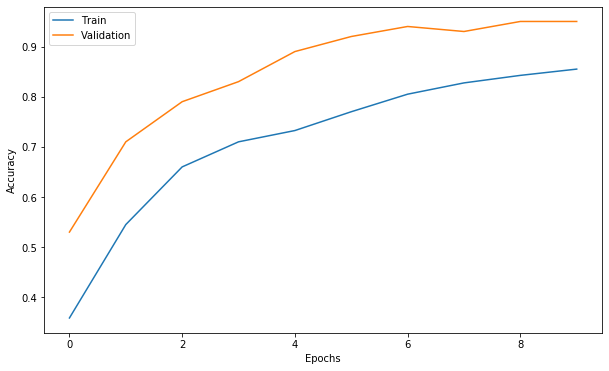

In [120]:
def plot_accuracy(history):
    fig = plt.figure(figsize=(10,6))
    plt.plot(history["acc"])
    plt.plot(history["val_acc"])
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.show()

plot_accuracy(history)

# Testing

In [ ]:
from keras.models import load_model
best_model = load_model(checkpoint_dir + "imageclassifier-0.2380-0.9400.hdf5")

In [ ]:
best_model.evaluate_generator(test_generator,
                              steps=len(test_generator))

In [ ]:
test_generator.reset()
probabilities = best_model.predict_generator(test_generator,
                                            steps=len(test_generator))
predicted_labels = np.argmax(probabilities, axis=-1)

In [ ]:
target_labels = test_generator.classes

from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)

In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()
    
# Find the class names that correspond to the indices
labels = [""] * num_classes
for k, v in test_generator.class_indices.items():
    labels[v] = k
    
plot_confusion_matrix(conf, labels, figsize=(10, 10))

In [ ]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(probabilities, axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {v:k for k,v in test_generator.class_indices.items()}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f" % (test_generator.filenames[i],
                                             index2class[predicted_labels[i]],
                                             probs_max[i]))

# Convertion

In [ ]:
import coremltools

labels = ["capricciosa", "diavola", "margherita", "marinara", "multiple", "other"]

coreml_model = coremltools.converters.keras.convert(best_model,
                                                   input_names="image",
                                                   image_input_names="image",
                                                   output_names="labelProbability",
                                                   predicted_feature_name="label",
                                                   red_bias=-1, # normalization to interval [-1,+1]
                                                   green_bias=-1,
                                                   blue_bias=-1,
                                                   image_scale=2/255.0,
                                                   class_labels=labels)

coreml_model.author = "Antonio Chiappetta"
coreml_model.license = "Public Domain"
coreml_model.short_description = "A machine learning model that has been trained to distinguish different types of pizza. Currently supported: margherita, marinara."
coreml_model.input_description["image"] = "Input image"
coreml_model.output_description["labelProbability"] = "Prediction probabilities"
coreml_model.output_description["label"] = "Class label of top prediction"

coreml_model.save("Pizza_keras.mlmodel")